Let's train an autoencoder on slices of a cube. We'll have a set of 3D Gaussian blobs as the training data.

In [2]:
import matplotlib.pyplot as plt
import numpy
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline

## Making the dataset

$16 \times 32 \times 32$ Gaussian blobs embedded in a unit cube.

In [3]:
def make_blob():
    dist = scipy.stats.multivariate_normal(mean=numpy.random.uniform(size=(3,)),
                                           cov=numpy.random.uniform(0.1, 0.2))
    coords = numpy.mgrid[0:1:1/16, 0:1:1/32, 0:1:1/32].reshape((3, -1)).T
    return dist.pdf(coords).reshape((16, 32, 32))

In [4]:
data = numpy.array([make_blob() for i in range(2000)])

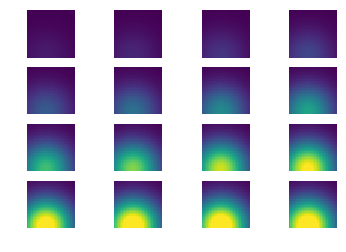

In [5]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data[100][i], vmin=0, vmax=1)
    plt.axis('off')

## Autoencoder

Now we'll make an autoencoder that takes $32 \times 32$ images, transforms them to a 5-dimensional space, and then transforms them back.

In [17]:
# https://github.com/sksq96/pytorch-vae/

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=2304):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, z_dim=32):
        super(VAE, self).__init__()
        h_dim = 2304
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten(),
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

    @staticmethod
    def loss(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD, BCE, KLD

In [18]:
vae = VAE(image_channels=16, z_dim=5).float()

In [29]:
optimiser = torch.optim.Adam(vae.parameters(), lr=1e-2)

In [ ]:
data = torch.from_numpy(data).float()

/home/alger/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/alger/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


Epoch[1/50] Loss: 141642672.000 141642640.000 33.995


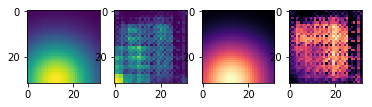

Epoch[2/50] Loss: 123681024.000 123681008.000 15.623


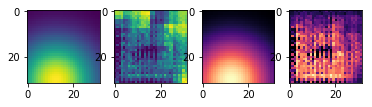

Epoch[3/50] Loss: 16829208.000 16829202.000 5.216


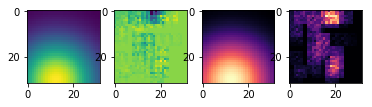

Epoch[4/50] Loss: 16777600.000 16777592.000 7.430


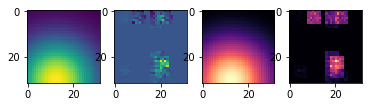

In [ ]:
epochs = 50
for epoch in range(epochs):
    recon, mu, logvar = vae(data)
    loss, bce, kld = vae.loss(recon, data, mu, logvar)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                            epochs, loss.data[0], bce.data[0], kld.data[0])
    print(to_print)
    plt.subplot(1, 4, 1)
    plt.imshow(data[100].numpy().mean(axis=0))
    plt.subplot(1, 4, 2)
    plt.imshow(recon[100].detach().numpy().mean(axis=0))
    plt.subplot(1, 4, 3)
    plt.imshow(data[100].numpy().std(axis=0), cmap='magma')
    plt.subplot(1, 4, 4)
    plt.imshow(recon[100].detach().numpy().std(axis=0), cmap='magma')
    plt.show()